In [1]:
#!/usr/bin/env python3
# coding: utf-8

% matplotlib inline
import numpy as np
import pandas as pd
import json
from sklearn.metrics import mean_squared_error as mse

BASE_PATH= "./data/"
def load_data(filename):
    address = BASE_PATH + filename 
    data = pd.read_csv(address, usecols=[0,1,2,3,4,5,7,8,9,10,11,12],dtype ={"fullVisitorId":str})
    JSON_COLUMNS = ['device','geoNetwork', 'totals', 'trafficSource']
    for column in JSON_COLUMNS:
        data = data.join(pd.DataFrame(data.pop(column).apply(pd.io.json.loads).values.tolist(), index=data.index).add_prefix(column + "_"))
    return data

def unique_col(df):
    unique_col=[]
    for i in df.columns:
        try:
            if df[i].nunique(dropna=False)==1:
                unique_col.append(i)
        except:
            continue
    return unique_col

def set_dtypes(df):
    continuous_col = ['totals_hits', 'totals_pageviews', 'totals_timeOnSite', 'totals_totalTransactionRevenue', 
                      'totals_transactionRevenue', 'totals_transactions', 'day_unique_user_count', 
                      'weekday_unique_user_count', 'weekofyear_unique_user_count','sum_pageviews_per_network_domain', 
                      'count_pageviews_per_network_domain', 'mean_pageviews_per_network_domain', 
                      'sum_hits_per_network_domain', 'count_hits_per_network_domain', 'mean_hits_per_network_domain', 
                      'mean_hits_per_day', 'sum_hits_per_day', 'sum_pageviews_per_region', 
                      'count_pageviews_per_region', 'mean_pageviews_per_region', 'month_unique_user_count', 
                      'date_weekday', 'date_month', 'date_day', 'date_weekofyear']
    for col in df.columns:
        if col in continuous_col:
            df[col]=df[col].astype(np.float)
        else:
            df[col]=df[col].astype(str)
    return df

def handle_missingData(df):
    for i in df.columns:
        if df[i].dtypes == float or int:
            df[i]=df[i].fillna(0)
        else:
            df[i]=df[i].fillna('0')
    return df

In [2]:
def feature_engineering(df):
    df['date']=pd.to_datetime(df.date.astype(str).apply(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:]))
    df['date_weekday']=df.date.dt.weekday
    df['date_month']=df.date.dt.month
    df['date_day']=df.date.dt.day
    df['date_weekofyear']=df.date.dt.weekofyear
    #browser&OS
    df['browser_category'] = df['device_browser'] + '_' + df['device_deviceCategory']
    df['browser_operatingSystem'] = df['device_browser'] + '_' + df['device_operatingSystem']
    #date feature
    df['month_unique_user_count'] = df.groupby('date_month')['fullVisitorId'].transform('nunique')
    df['day_unique_user_count'] = df.groupby('date_day')['fullVisitorId'].transform('nunique')
    df['weekday_unique_user_count'] = df.groupby('date_weekday')['fullVisitorId'].transform('nunique')
    df['weekofyear_unique_user_count'] = df.groupby('date_weekofyear')['fullVisitorId'].transform('nunique')
    # pageview statistics about per network domain
    df['sum_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('sum')
    df['count_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('count')
    df['mean_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean')
    # hits statistics about per network domain
    df['sum_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('sum')
    df['count_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('count')
    df['mean_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean')
    # hits statistics feature about per day
    df['mean_hits_per_day'] = df.groupby(['date_day'])['totals_hits'].transform('mean')
    df['sum_hits_per_day'] = df.groupby(['date_day'])['totals_hits'].transform('sum')
    # pageview statistic feature about region
    df['sum_pageviews_per_region'] = df.groupby('geoNetwork_region')['totals_pageviews'].transform('sum')
    df['count_pageviews_per_region'] = df.groupby('geoNetwork_region')['totals_pageviews'].transform('count')
    df['mean_pageviews_per_region'] = df.groupby('geoNetwork_region')['totals_pageviews'].transform('mean')
    return df

##### Load data

In [3]:
train_data = load_data("train_v2.csv")
test_data = load_data("test_v2.csv")
#set dtype
train_data = set_dtypes(train_data)
test_data = set_dtypes(test_data)

##### Feature engineering & Preprocessing

In [4]:
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

In [5]:
for i in train_data.columns:
    if i not in test_data.columns:
        print(i)
        train_data=train_data.drop([i],axis=1)

trafficSource_campaignCode


In [6]:
#drop unique col
train_data_UniqueCol = unique_col(train_data)
test_data_UniqueCol=unique_col(test_data)
train_data_UniqueCol==test_data_UniqueCol
train_data=train_data.drop(train_data_UniqueCol,axis=1)
test_data=test_data.drop(test_data_UniqueCol,axis=1)

In [7]:
#drop useless col
useless_col = ['date','visitId','visitStartTime', ]
train_data=train_data.drop(useless_col, axis=1)
test_data=test_data.drop(useless_col, axis=1)

In [8]:
#set dtype
train_data = set_dtypes(train_data)
test_data = set_dtypes(test_data)

In [9]:
#handle missing data
train_data= handle_missingData(train_data)
test_data = handle_missingData(test_data)

##### Categorical_feature factorize

In [10]:
train_data_Y = train_data['totals_transactionRevenue'].apply(np.log1p)
train_data_X = train_data.drop(['totals_transactionRevenue'],axis=1)
test_data_Y = test_data['totals_transactionRevenue'].apply(np.log1p)
test_data_X = test_data.drop(['totals_transactionRevenue'],axis=1)
train_data_X_fullVisitorId =  train_data_X['fullVisitorId']
train_data_X  = train_data_X.drop(['fullVisitorId'],axis=1)
test_data_X_fullVisitorId =  test_data_X['fullVisitorId']
test_data_X  = test_data_X.drop(['fullVisitorId'],axis=1)
cate_col = []
for i in train_data_X.columns:
    if train_data_X[i].dtypes == object:
        cate_col.append(i)
for col in cate_col:
    train_data_X[col], indexer = pd.factorize(train_data_X[col])
    test_data_X[col], indexer = pd.factorize(test_data_X[col])

##### Model train

In [11]:
import lightgbm as lgb 
test_Dataset = lgb.Dataset(data=test_data_X, label=test_data_Y, categorical_feature=cate_col)
train_Dataset = lgb.Dataset(data=train_data_X, label=train_data_Y, categorical_feature=cate_col)

parameters ={'application': 'regression',
            'metric':'rmse',
            'learning_rate':0.03,
            'num_boost_round':1000,
            'num_leaves':62,
             "min_child_samples" : 1,
            'subsample':0.9,
            'colsample_bytree':0.9,
            'random_state':2019,
             "bagging_frequency" : 5,
             'device':'cpu'
            }

model = lgb.train(  
                    params = parameters,
                    train_set=train_Dataset,
                    valid_sets=test_Dataset,
                    categorical_feature =cate_col,
                    early_stopping_rounds =50,
                    verbose_eval = 10
                 )

D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	valid_0's rmse: 1.39854
[20]	valid_0's rmse: 1.03442
[30]	valid_0's rmse: 0.764141
[40]	valid_0's rmse: 0.58116
[50]	valid_0's rmse: 0.431654
[60]	valid_0's rmse: 0.321714
[70]	valid_0's rmse: 0.243321
[80]	valid_0's rmse: 0.184887
[90]	valid_0's rmse: 0.143752
[100]	valid_0's rmse: 0.111871
[110]	valid_0's rmse: 0.0889841
[120]	valid_0's rmse: 0.0736156
[130]	valid_0's rmse: 0.0639932
[140]	valid_0's rmse: 0.0562192
[150]	valid_0's rmse: 0.0515632
[160]	valid_0's rmse: 0.048747
[170]	valid_0's rmse: 0.0470965
[180]	valid_0's rmse: 0.0461238
[190]	valid_0's rmse: 0.0455006
[200]	valid_0's rmse: 0.0452295
[210]	valid_0's rmse: 0.0450914
[220]	valid_0's rmse: 0.0449207
[230]	valid_0's rmse: 0.0451098
[240]	valid_0's rmse: 0.0450234
[250]	valid_0's rmse: 0.0447018
[260]	valid_0's rmse: 0.0443874
[270]	valid_0's rmse: 0.0443573
[280]	valid_0's rmse: 0.0442177
[290]	valid_0's rmse: 0.0440796
[300]	valid_0's rmse: 0.0440574
[

##### Plot Feature importance

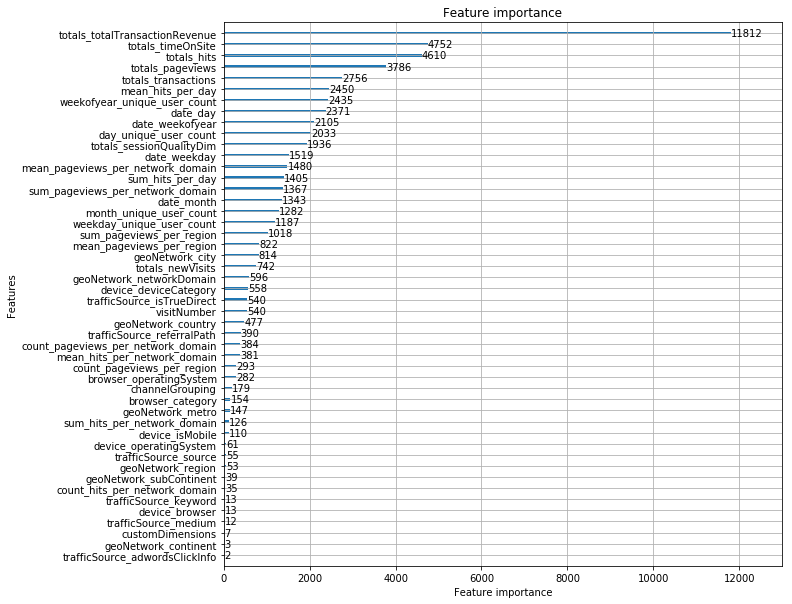

In [12]:
lgb.plot_importance(model,figsize=(10,10))

##### Predict

In [41]:
predict_result = model.predict(test_data_X)

In [42]:
predict_log  =  pd.Series(predict_result,name="PredictedLogRevenue")

In [43]:
predict_revenue = np.expm1(predict_log)

##### Model Save

In [44]:
model.save_model("best_regression_use_revenue.txt")

##### Calculate score of rmse

In [48]:
cal_score = pd.concat([test_data_X_fullVisitorId, test_data_6['totals_transactionRevenue'], predict_revenue], axis=1).groupby(['fullVisitorId'])["PredictedLogRevenue","totals_transactionRevenue"].agg(sum)

In [50]:
cal_score.PredictedLogRevenue = cal_score.PredictedLogRevenue.apply(np.log1p)
cal_score.totals_transactionRevenue=cal_score.totals_transactionRevenue.apply(np.log1p)

In [51]:
score=mse(cal_score["totals_transactionRevenue"], cal_score["PredictedLogRevenue"])**0.5
score

0.04699698160520673

##### Save csv for submission

In [54]:
result = pd.concat([test_data_X_fullVisitorId, predict_revenue], axis=1).groupby(['fullVisitorId']).agg(sum)
result["PredictedLogRevenue"] = result["PredictedLogRevenue"].apply(np.log1p)

In [56]:
result.to_csv("./data/submission.csv")